In [1]:
import tensorflow as tf

# Get GPU device name
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

if torch.cuda.is_available():

  # tell Pytorch to use the GPU
  device = torch.device('cuda')

  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [3]:
!pip install transformers

In [4]:
import urllib
import os

if not os.path.exists('./data/'):
  os.mkdir('./data/')

files = [
         ('./data/attack_annotated_comments.tsv', 'https://ndownloader.figshare.com/files/7554634'),
         ('./data/attack_annotations.tsv',        'https://ndownloader.figshare.com/files/7554637')
]

for (filename, url) in files:
  if not os.path.exists(filename):
    print('Downloading:', filename)
    urllib.request.urlretrieve(url, filename)
    print('Done!')

In [5]:
import pandas as pd

print('Parsing the dataset .tsv file...')
comments = pd.read_csv('./data/attack_annotated_comments.tsv', sep='\t', index_col=0)
annotations = pd.read_csv('./data/attack_annotations.tsv', sep='\t')
print('Done!')

Parsing the dataset .tsv file...
Done!


In [6]:
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


In [7]:
comments[['comment', 'split']].groupby('split').count()

,comment
split,
dev,23160
test,23178
train,69526


In [8]:
# create labels and join them with comments
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

comments['attack'] = labels

In [9]:
comments['comment'] = comments['comment'].apply(lambda x: x.replace('NEWLINE_TOKEN', ' '))
comments['comment'] = comments['comment'].apply(lambda x: x.replace('TAB_TOKEN', ' '))

In [10]:
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

In [11]:
import textwrap
import random

wrapper = textwrap.TextWrapper(width=80)

attack_examples = train_comments.query('attack')['comment']

for i in range(10):
  j = random.choice(attack_examples.index)

  print('')
  print(wrapper.fill(attack_examples[j]))
  print('')


Get a life brotha== fick me looking at sum of the shit u been doin. are you
queer cunt or what?  and i quote  As I'm currently away from my home ADSL
network, I'll be limited since I'm now using a bandwith limited mobile limited
connection. I hope to be back when the issue is fixed.  if that dont scream a
fucking wanker i don't know what does.  ==


  == You are == Spastic guy, that don't want to roll over and do what I
suggested moment ago....


  == CENSORSHIP ==  Hi Toure Neblett, I realize you think you are above
criticism on account of your complexion and your hatred of your white relatives.
But suck it in and quit censoring little boy.  If you can't reply to debate,
throwing a tantrum is immature.  Oh, and Janet Jackson will never ever sleep
with you!


  == Fuck You ==  Nigga, fuck you.  Flocka aint a gangster, so he's not Gangsta
rap!  Kids these days are so fucking stupid and mainstream..


 :This is either a completely failed attempt at joking sarcasm, or you're a
hypocrite.

In [12]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [13]:
text = train_comments.iloc[0].comment
tokens = tokenizer.tokenize(text)

# print out the list of tokens and see what we truncate
print('==== First 512 tokens: ====\n')
print(wrapper.fill(str(' '.join(tokens[0:512]))))
print('')
print('\n==== Remaining {:,} tokens: ====\n'.format(len(tokens) - 512))
print(wrapper.fill(str(' '.join(tokens[512:]))))

==== First 512 tokens: ====

` - this is not ` ` creative ` ` . those are the dictionary definitions of the
terms ` ` insurance ` ` and ` ` en ##sur ##ance ` ` as properly applied to ` `
destruction ` ` . if you don ' t understand that , fine , legitimate criticism ,
i ' ll write up ` ` three man cell ` ` and ` ` bounty hunter ` ` and then it
will be easy to understand why ` ` ensured ` ` and ` ` ins ##ured ` ` are
different - and why both differ from ` ` assured ` ` . the sentence you quote is
absolutely neutral . you just aren ' t familiar with the underlying theory of
strike - back ( e . g . submarines as employed in nuclear warfare ) guiding the
insurance , nor likely the three man cell structure that kept the ira from being
broken by the british . if that ' s my fault , fine , i can fix that to explain
. but the ##r ' es nothing ` ` personal ` ` or ` ` creative ` ` about it . i ' m
tired of arguing with you . re : the other article , ` ` multi - party ` ` turns
up plenty , and the

In [ ]:
# A few ways to deal with this problem is truncation and chunking

import numpy as np

input_ids = []
lengths = []

print('Tokenizing comments...')
for sent in train_comments.comment:
  if ((len(input_ids) % 20000) == 0):
    print('Read {:,} comments.'.format(len(input_ids)))
    
  # 'encode' will:
  # (1) tokenize the sentence
  # (2) prepend the [CLS] token to the start
  # (3) append the [SEP] token to the start
  # (4) map tokens to their IDs
  encoded_sent = tokenizer.encode(
        sent,                      # sentence to encode
        add_special_tokens = True, # add [CLS] and [SEP]
        #max_length = 512,
        #return_tensors = 'pt',
    )

  input_ids.append(encoded_sent)
  lengths.append(len(encoded_sent))

print('Done!')
print('{:>10,} comments'.format(len(input_ids)))

In [15]:
# get labels and convert from booleans to ints
labels = train_comments.attack.to_numpy().astype(int)

In [16]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# pad input tokens with value 0
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long',
                          value=0, truncating='post', padding='post')

print('\nDone!')


Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0

Done!


In [17]:
# attention masks make explicit reference to which tokens are actual words vs padded words

attention_masks = []

for sent in input_ids:

  # mask 
  att_mask=[int(token_id > 0) for token_id in sent]

  attention_masks.append(att_mask)

In [18]:
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)

train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1)

# convert inputs and labels into torch tensors
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [20]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )

In [22]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [23]:
## HELPER FUNCTIONS - accuracy & elapsed time formats
import time
import datetime
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
import random

# training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# store the average loss after each epoch so we can plot them
loss_values = []

# for each epoch in training...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # perform one full pass over the training set

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # measure how long the training epoch takes
    t0 = time.time()

    # reset the total loss for this epoch
    total_loss = 0

    # don't be mislead--the call to 'train' just changes the *mode*
    # 'dropout' and 'batchnorm' layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # for each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # as we unpack the batch, we'll also copy each tensor to the GPU using the 
        # 'to' method.
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # always clear any previously calculated gradients before performing a
        # backward pass because PyTorch doesn't do this automatically
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # perform a forward pass (evaluate the model on this training batch)
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # the call to 'model' always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # 'loss' is a Tensor containing a single value; 
        # the '.item()' function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # perform a backward pass to calculate the gradients
        loss.backward()

        # clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters and take a step using the computed gradient
        optimizer.step()

        # update the learning rate
        scheduler.step()

    # calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # store the loss value for plotting the learning curve
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # after the completion of each training epoch, measure our performance on
    # validation set

    print("")
    print("Running Validation...")

    t0 = time.time()

    # put the model in evaluation mode
    model.eval()

    # tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # evaluate data for one epoch
    for batch in val_dataloader:
        
        # add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # anpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # forward pass, calculate logit predictions
            # this will return the logits rather than the loss because we have
            # not provided labels
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        

        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # calculate the accuracy for this batch of test sentences
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # track the number of batches
        nb_eval_steps += 1

    # report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,956.    Elapsed: 0:00:49.
  Batch    80  of  1,956.    Elapsed: 0:01:38.
  Batch   120  of  1,956.    Elapsed: 0:02:27.
  Batch   160  of  1,956.    Elapsed: 0:03:17.
  Batch   200  of  1,956.    Elapsed: 0:04:06.
  Batch   240  of  1,956.    Elapsed: 0:04:55.
  Batch   280  of  1,956.    Elapsed: 0:05:45.
  Batch   320  of  1,956.    Elapsed: 0:06:35.
  Batch   360  of  1,956.    Elapsed: 0:07:24.
  Batch   400  of  1,956.    Elapsed: 0:08:14.
  Batch   440  of  1,956.    Elapsed: 0:09:03.
  Batch   480  of  1,956.    Elapsed: 0:09:53.
  Batch   520  of  1,956.    Elapsed: 0:10:42.
  Batch   560  of  1,956.    Elapsed: 0:11:31.
  Batch   600  of  1,956.    Elapsed: 0:12:20.
  Batch   640  of  1,956.    Elapsed: 0:13:09.
  Batch   680  of  1,956.    Elapsed: 0:13:58.
  Batch   720  of  1,956.    Elapsed: 0:14:47.
  Batch   760  of  1,956.    Elapsed: 0:15:36.
  Batch   800  of  1,956.    Elapsed: 0:16:25.
  Batch   840  of

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


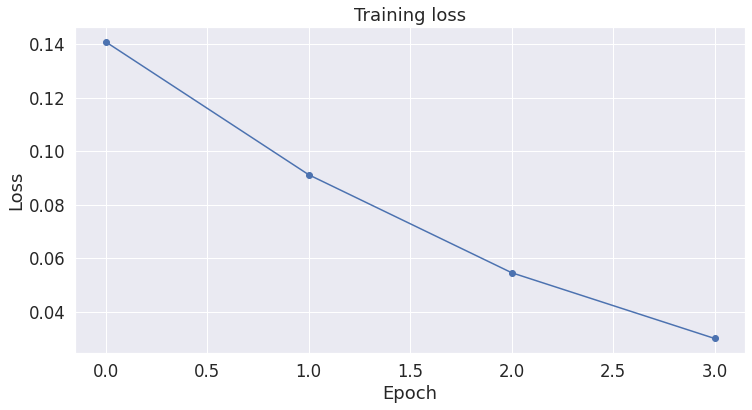

In [25]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# learning curve
plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
# tokenize all of the sentences and map the tokens to thier word IDs
test_input_ids = []

# for every sentence...
for sent in test_comments.comment:
    # 'encode' will:
    #   (1) tokenize the comments
    #   (2) prepend the [CLS] token to the start
    #   (3) append the [SEP] token to the end
    #   (4) map tokens to their IDs
    encoded_sent = tokenizer.encode(
                        sent,                      # sentence encoding
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    test_input_ids.append(encoded_sent)

test_labels = test_comments.attack.to_numpy().astype(int)

test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# create attention masks
test_attention_masks = []

# create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask) 

# convert to tensors
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

# set batch size  
batch_size = 32  

# create the DataLoader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [30]:
## PREDICTION on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

model.eval()

predictions, true_labels = [], []

t0 = time.time()

for (step, batch) in enumerate(test_dataloader):

  batch = tuple(t.to(device) for t in batch)

  if step % 100 == 0 and not step == 0:

    elapsed = format_time(time.time() - t0)

    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():

    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask)
    
    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    Done!')

Predicting labels for 23,178 test sentences...


NameError: ignored

In [ ]:
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
predictions[0:10]

In [ ]:
true_labels[0:10]

In [ ]:
from sklearn.metrics import roc_auc_score

p1 = prediction[:,1]

auc = roc_auc_score(true_labels, p1)
print('Test ROC AUC: %.3f' %auc)